# Análisis turismo en puerto

### Análisis de las series de tiempo

Para empezar el análisis descriptivo de las series de tiempo se comenzará con la graficación de las series y su desestacionalización.

In [1]:
import warnings; 
warnings.simplefilter('ignore')

In [2]:
#pip install sktime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sktime 
import seaborn as sns
colors = sns.color_palette('tab10')
import prophet
from sklearn.metrics import mean_absolute_percentage_error
import functions

Importing plotly failed. Interactive plots will not work.


In [3]:
disponibilidad_ocupacion = pd.read_csv('Disponibilidad y ocupacion.csv')
disponibilidad_ocupacion.drop('Unnamed: 10', axis = 1, inplace = True)


In [4]:
for i in disponibilidad_ocupacion.columns:
    disponibilidad_ocupacion.loc[disponibilidad_ocupacion[i]== 0, i] = None


disponibilidad_ocupacion.isna().sum()

Date                                  0
Cuartos_disp                          0
Cuartos_ocupados_total                2
Cuartos_ocupados_nacionales           2
Cuartos_ocupados_extranjeros          3
Porcentaje_de_ocupacion_total         2
Porcentaje_de_ocupacion_nacionales    2
Porcentaje_de_ocupacion_extranjera    3
Porcentaje_turistas_nacionales        2
Porcentaje_turistas_extranjeros       3
dtype: int64

In [5]:
disponibilidad_ocupacion['Date'] = pd.to_datetime(disponibilidad_ocupacion['Date'], dayfirst= True)
disponibilidad_ocupacion.index = disponibilidad_ocupacion['Date']
X = disponibilidad_ocupacion['Date']
disponibilidad_ocupacion.drop('Date', axis = 1, inplace = True)

In [6]:
nominales = [c for c in disponibilidad_ocupacion.columns if 'Porcentaje' not in c and c != 'Date']

In [7]:
porcentajes = [c for c in disponibilidad_ocupacion if 'Porcentaje'  in c]
disponibilidad_ocupacion[porcentajes] = disponibilidad_ocupacion[porcentajes]*100


In [8]:
# Transformación logarítimica
disponibilidad_ocupacion = np.log(disponibilidad_ocupacion)
nominales = nominales = disponibilidad_ocupacion[nominales]
porcentajes = disponibilidad_ocupacion[porcentajes]

In [9]:
def plot_graphs(df, X, sharey = False):

    '''
    Function to plot time series graphs

    Parameters:
    - df: Dataframe object in which the variables are located
    - X: Pandas series datetime object
    - sharey: Default = False. Boolean used as a parameter in the subplots matplotlib's function.

    Returns:

    - subplots with the time series graph
    '''

    columns = [c for c in df.columns if c != 'Date']

    fig, axs = plt.subplots(ncols = len(columns), sharex = True, figsize = (20,5), sharey = sharey )
    for i, col in enumerate(columns):
        y = df[col]
        
        axs[i].plot(X,y, color = colors[i])
        axs[i].set_title(f'{col}')
        axs[i].set_xlabel('Fecha')
        #axs[i].tight_layout()
        plt.tight_layout
        
        

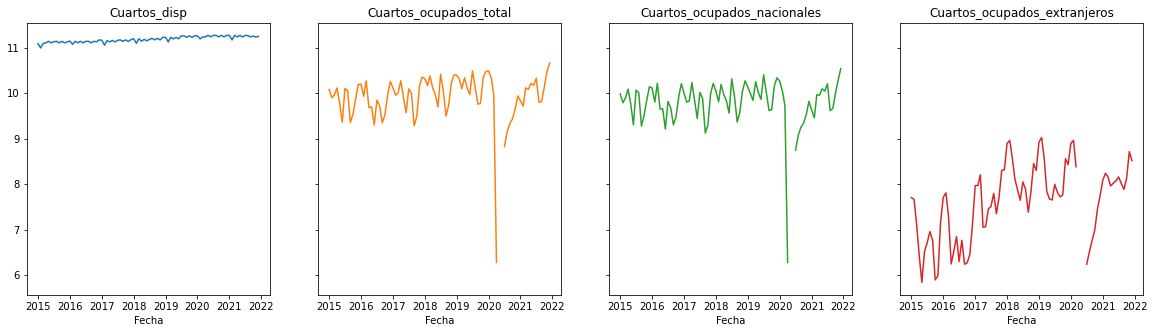

In [10]:
# Gráfico de las variables nominales
plot_graphs(nominales, X, True)

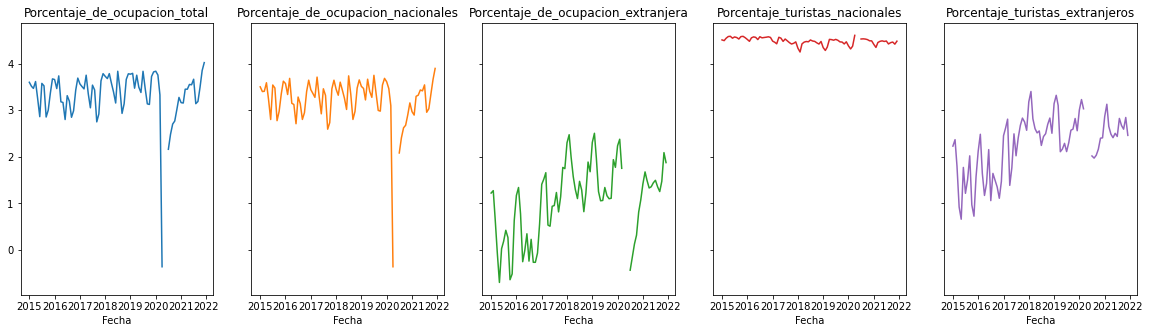

In [11]:
# Gráfico de las variables porcentuadas
plot_graphs(porcentajes, X, True)

### Observaciones
* Es necesario estabilizar la varianza de la mayoría de las series de tiempo.
* En la mayoría de las series de tiempo el periodo de la pandemia de 2020 es un outlier.
* Quizá valga la pena remplazar estos outliers por un pronóstico para el entrenamiento.


## Modelado de referencia

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

,a_additive,a_multiplicative
Cuartos_disp,0.001175,0.001164
Cuartos_ocupados_total,0.085488,0.080381
Cuartos_ocupados_nacionales,0.080108,0.075813
Cuartos_ocupados_extranjeros,0.138958,0.123193


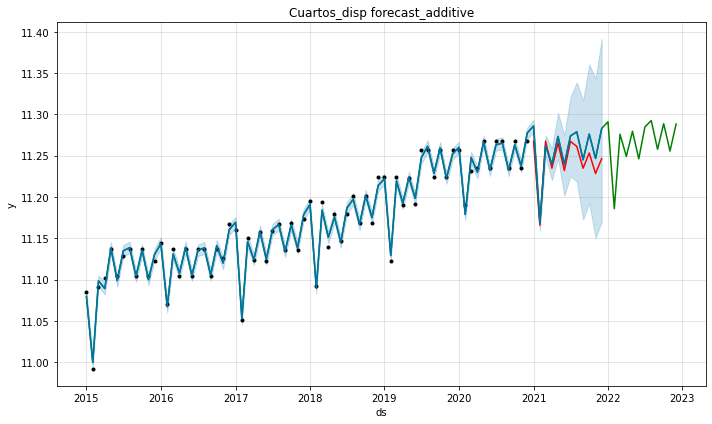

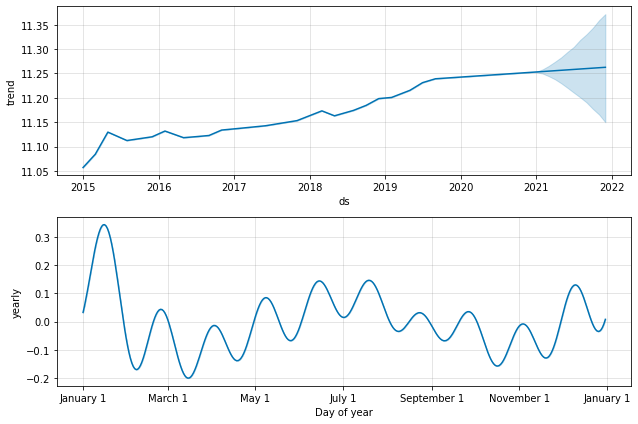

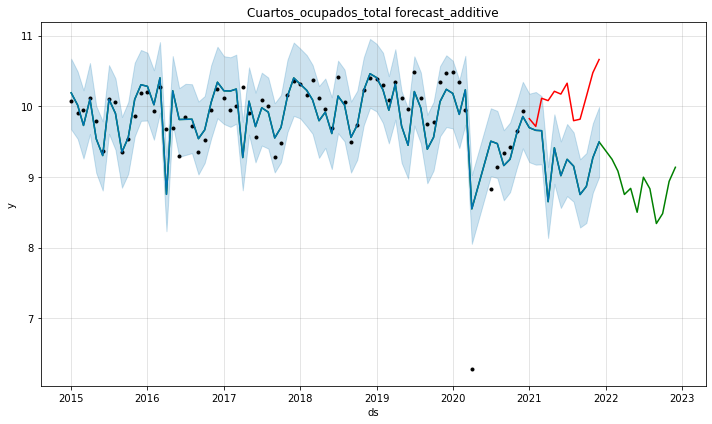

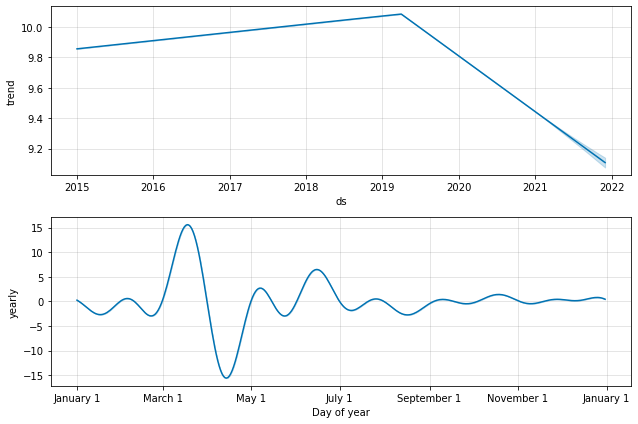

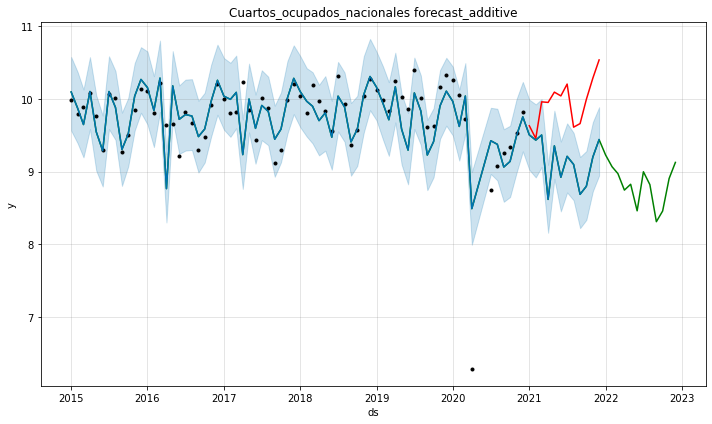

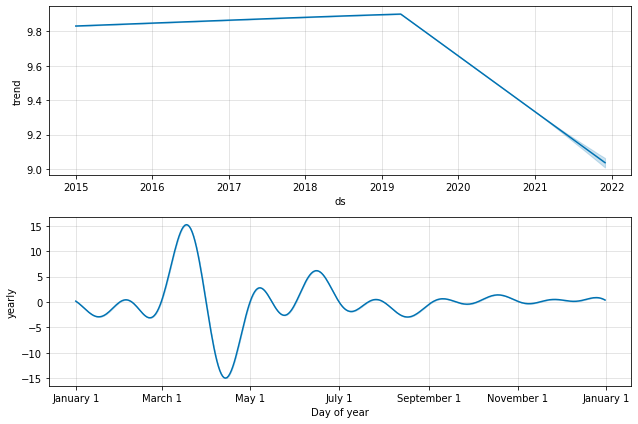

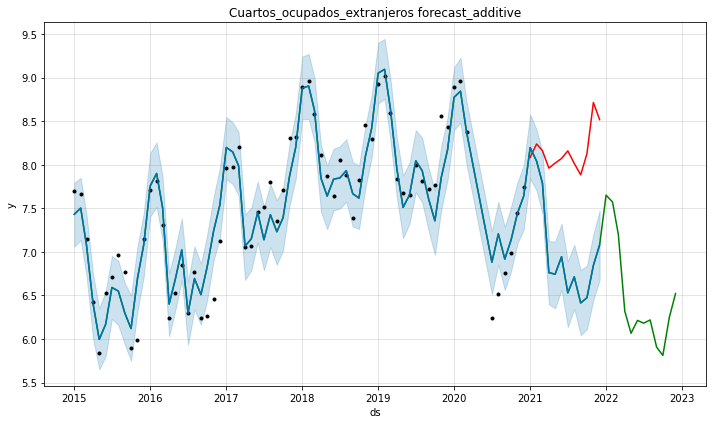

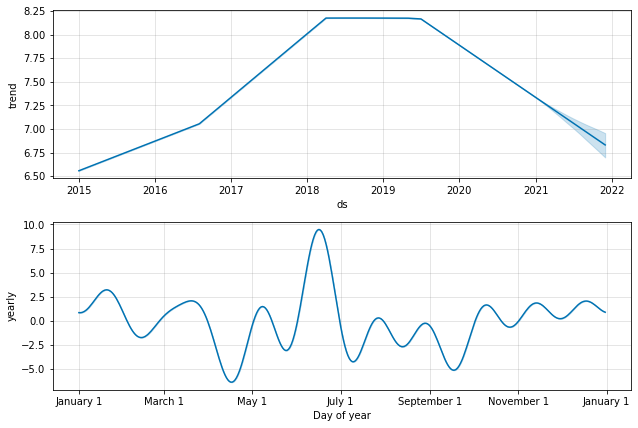

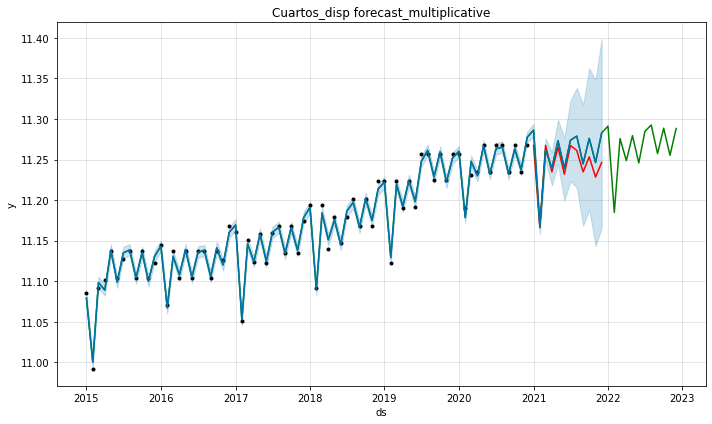

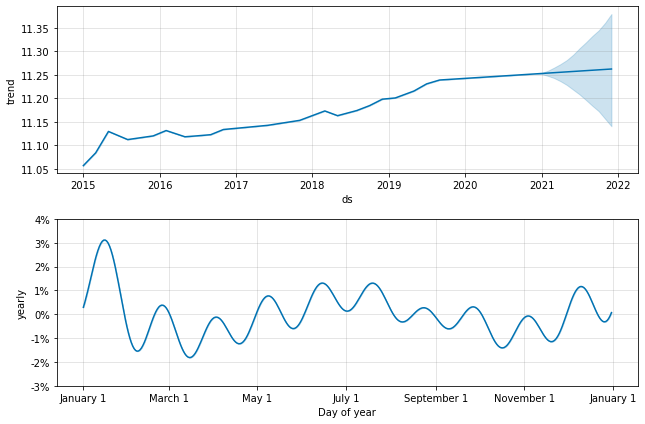

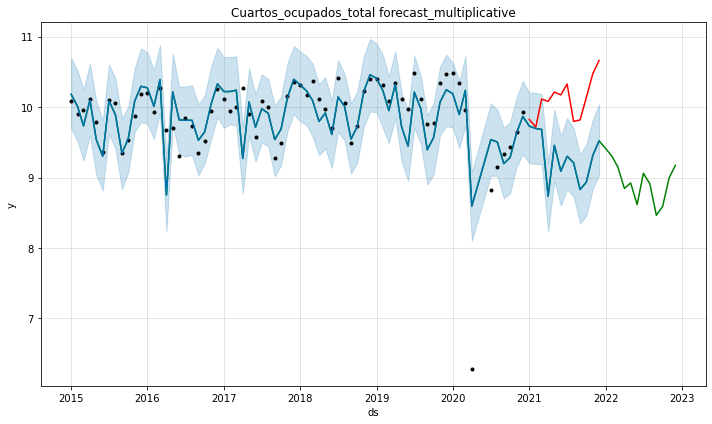

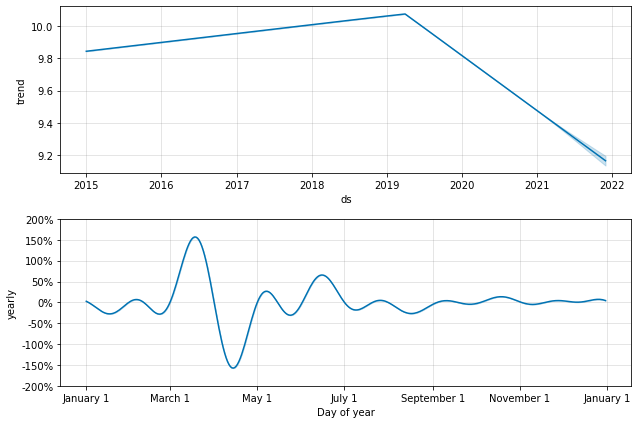

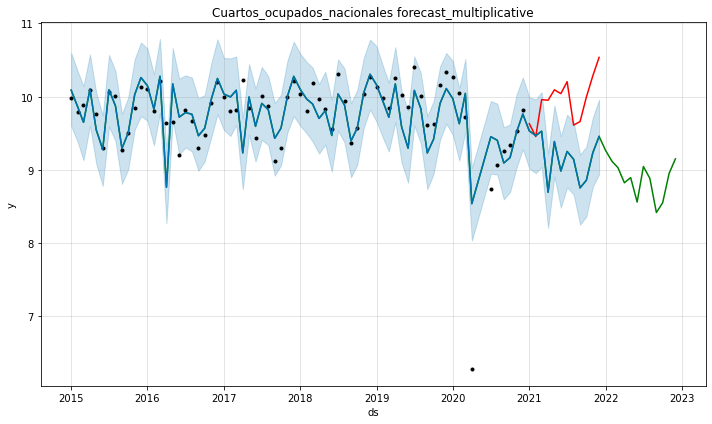

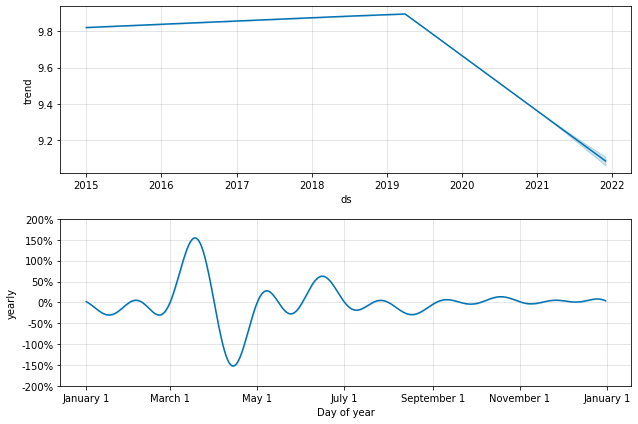

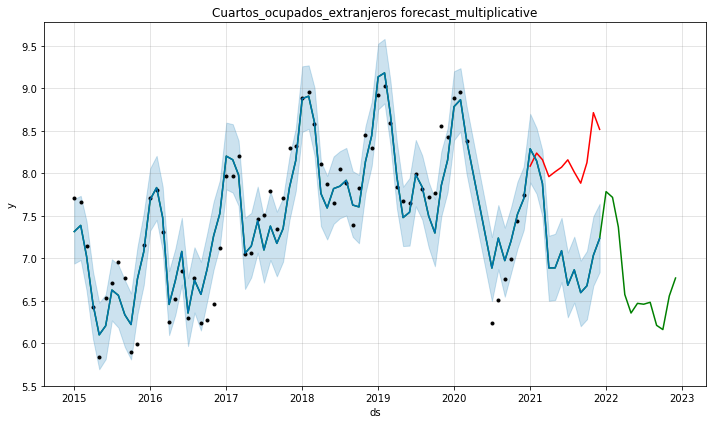

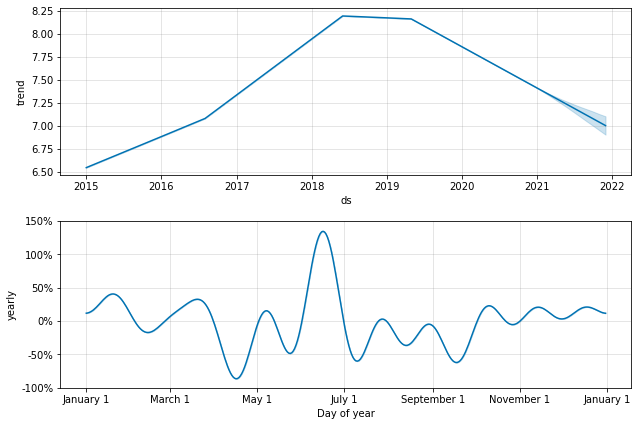

In [12]:
functions.create_models(nominales, ['a'])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

,b_additive,b_multiplicative
Porcentaje_de_ocupacion_total,0.130168,0.119498
Porcentaje_de_ocupacion_nacionales,0.138926,0.127677
Porcentaje_de_ocupacion_extranjera,0.266324,0.491970
Porcentaje_turistas_nacionales,0.012181,0.012370
Porcentaje_turistas_extranjeros,0.097322,0.136742


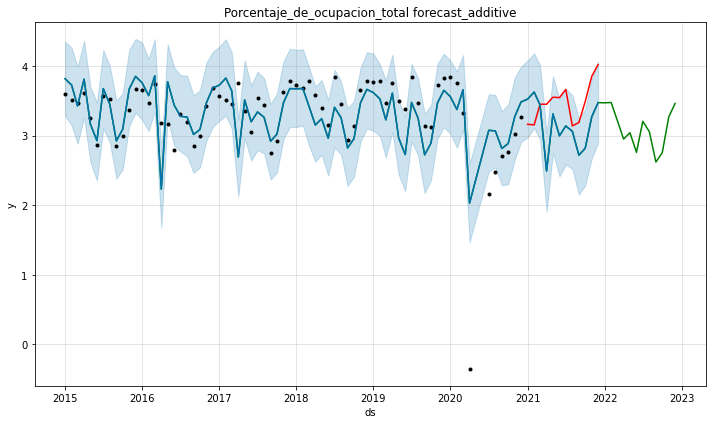

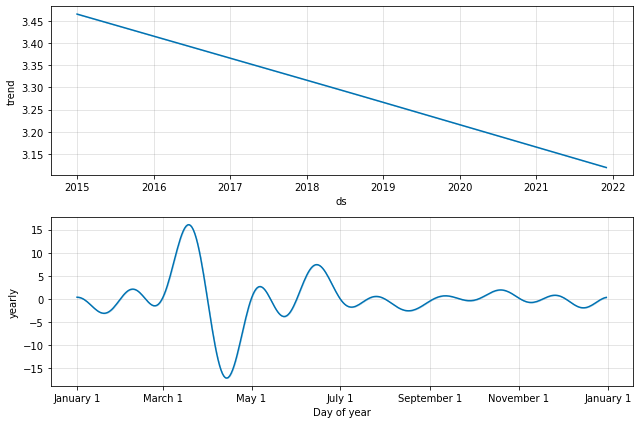

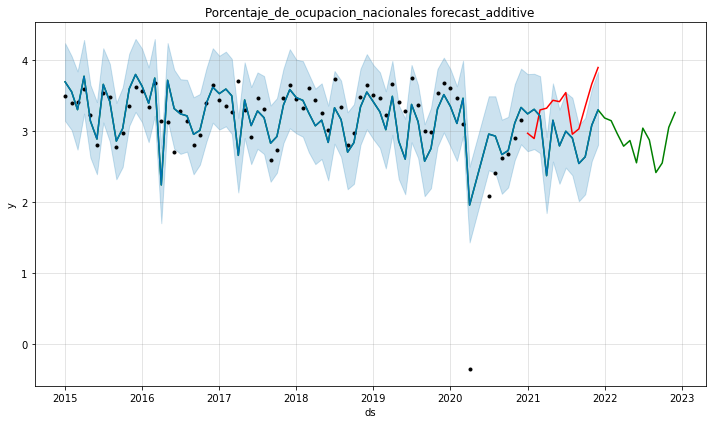

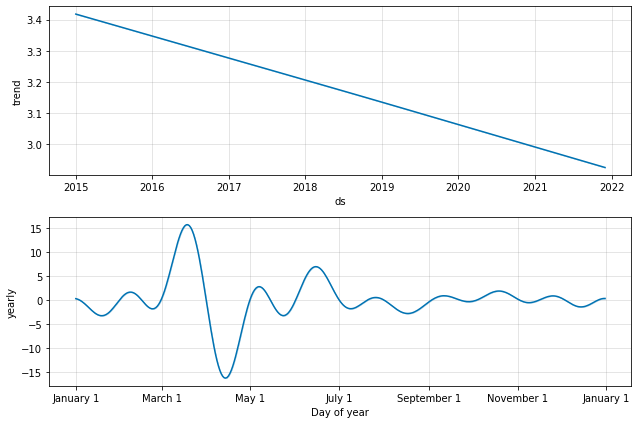

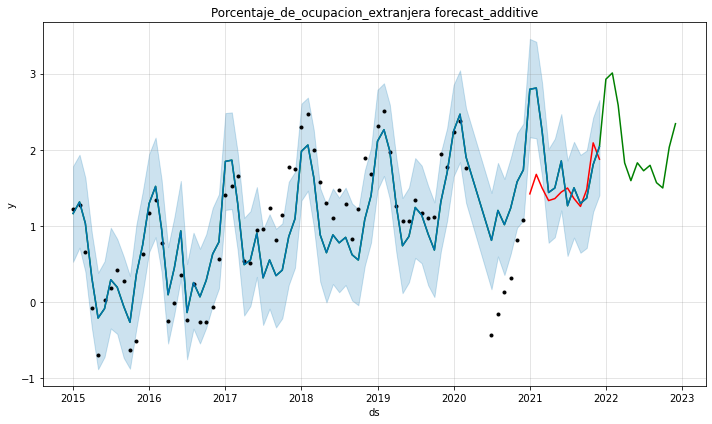

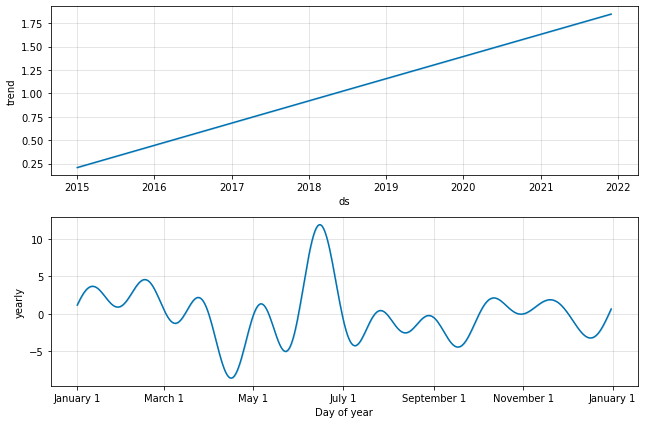

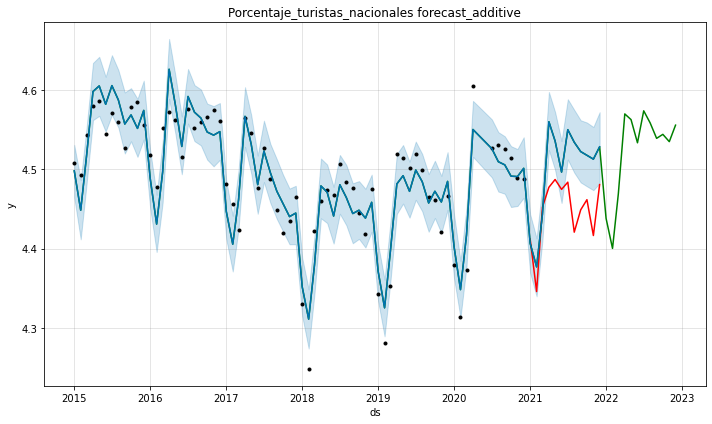

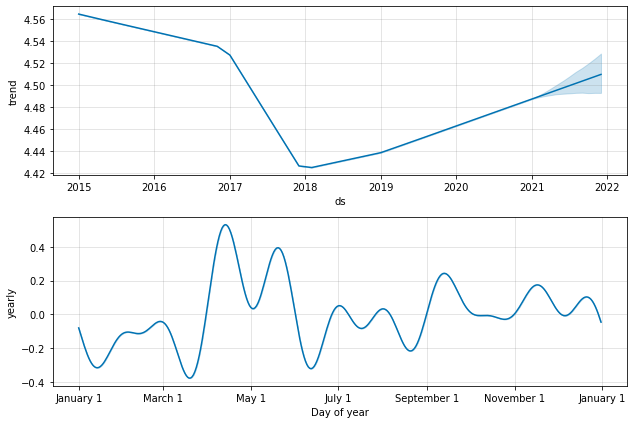

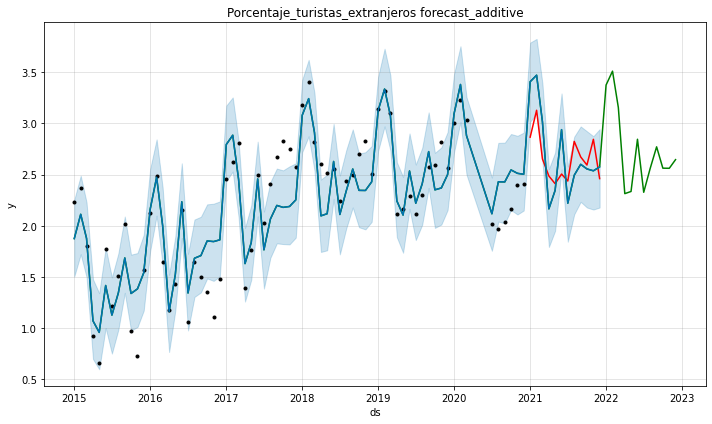

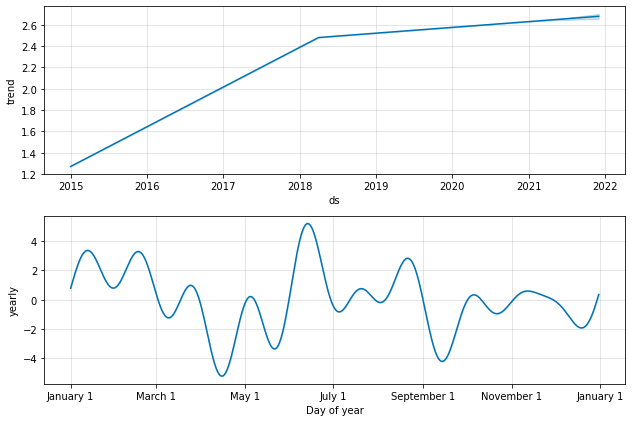

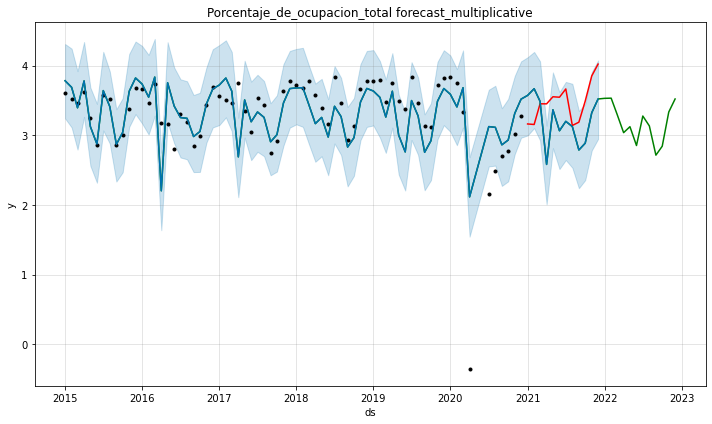

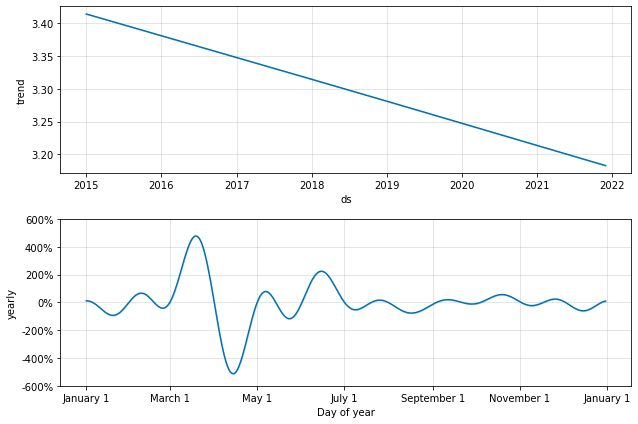

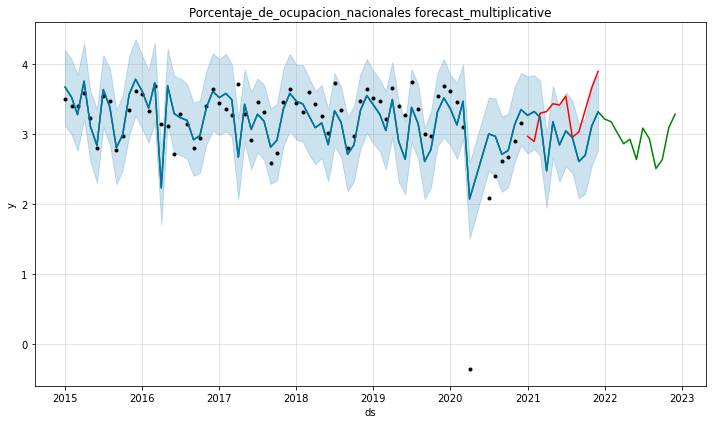

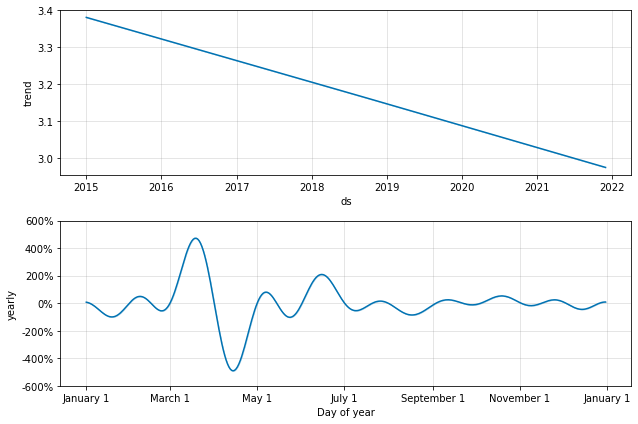

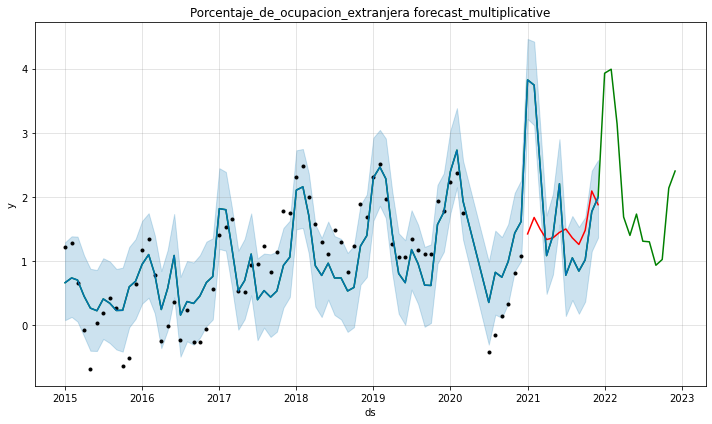

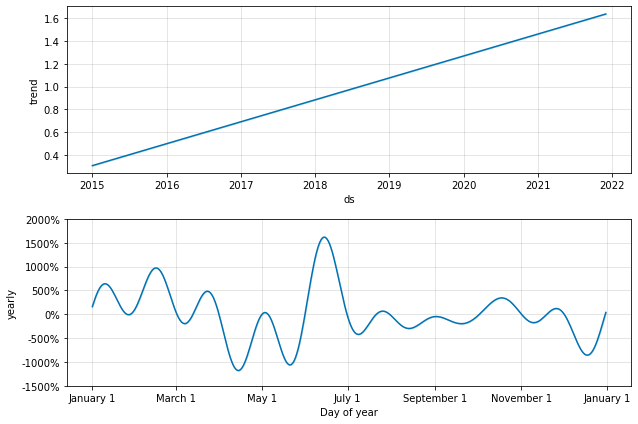

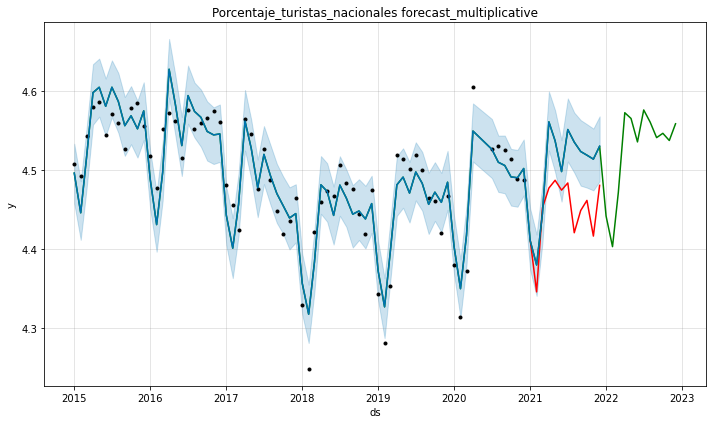

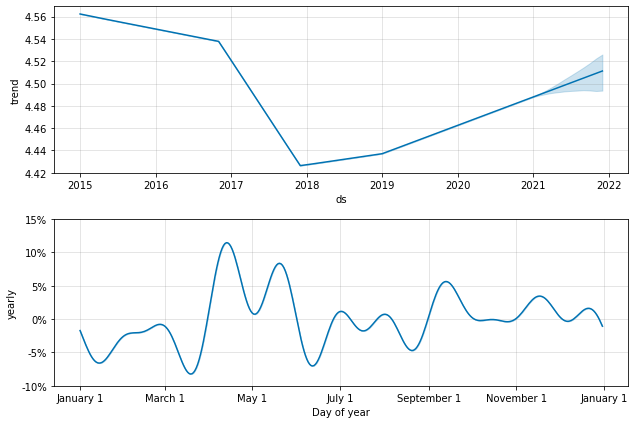

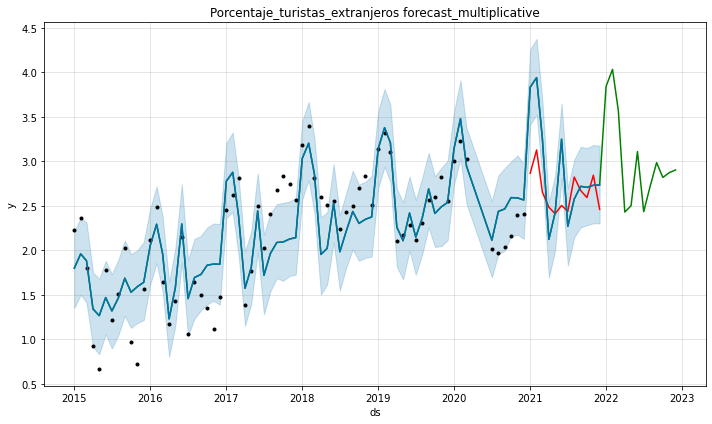

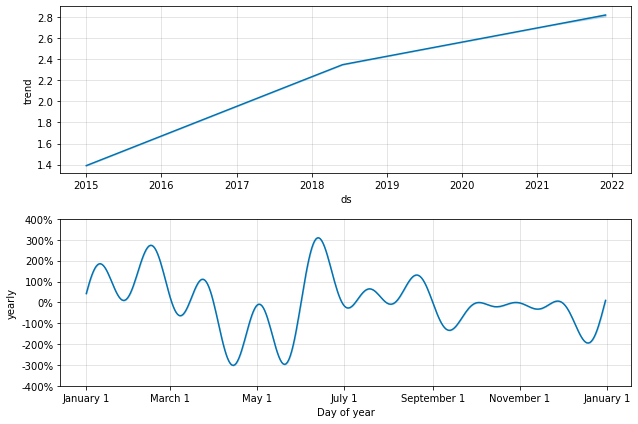

In [13]:
functions.create_models(porcentajes, ['b'])

### Including covid lockdown to our model


In [14]:
def time_series_forecasting_covid(df, period_to_forecast, seasonality_mode):
    # We define the lockdows duration

    lockdowns = pd.DataFrame([
        {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
        {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
        {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
        {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    ])


    for t_col in ['ds', 'ds_upper']:
        lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
    lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
    
    
    features = [c for c in df.columns if df[c].dtype != 'datetime64']
    forecast_error = {}
    for feature in features:
        
        # Building the time series dataframe
        dataframe = pd.DataFrame()
        dataframe['y'] = df[feature]
        dataframe['ds'] = df.index
        
        #Train_test_split
        # Usaremos los datos hasta 2020 para el train y los datos de 2021 pora el test
        train = dataframe.where(dataframe['ds']<pd.to_datetime('2021-01-01')).dropna()
        test = dataframe.where(dataframe['ds'] >= pd.to_datetime('2021-01-01')).dropna()
        
        
        
        
        
        # Training the model
       # Python
        m = prophet.Prophet(holidays=lockdowns)
        m = m.fit(train)
        future = m.make_future_dataframe(periods=period_to_forecast, freq = 'MS')
        forecast = m.predict(future)
        
        
        # Evaluating the model
        y_pred = forecast['yhat'][-12:]
        mape = mean_absolute_percentage_error(test['y'], y_pred)
        forecast_error[feature] = mape
        
        
        # Future prediction
        future_2 = m.make_future_dataframe(periods = 24, freq = 'MS')
        future_2.where(future_2['ds'] >= pd.to_datetime('2023-01-01'))
        prediction_2 = m.predict(future_2)
        prediction_2.index = future_2['ds']
        prediction_2 = prediction_2['yhat']
       
        
        

        # Graphs
        fig,axs = plt.subplots(figsize=(10, 6))
        axs.set_title(f'{feature} forecast')
        axs.plot(test['y'], color = 'red')
        axs.plot(prediction_2, color = 'green')
        fig = m.plot(forecast, ax = axs)
        
        fig3 = m.plot_components(forecast)
        
        
    # Errores
    error = pd.DataFrame([forecast_error], index = [tipo])
        
    return error

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NameError: name 'tipo' is not defined

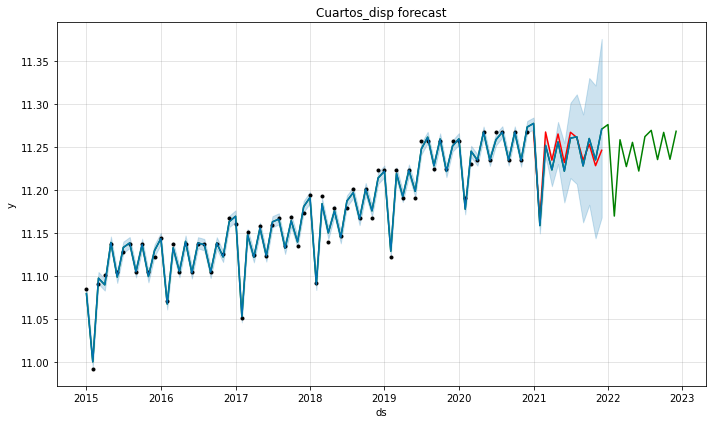

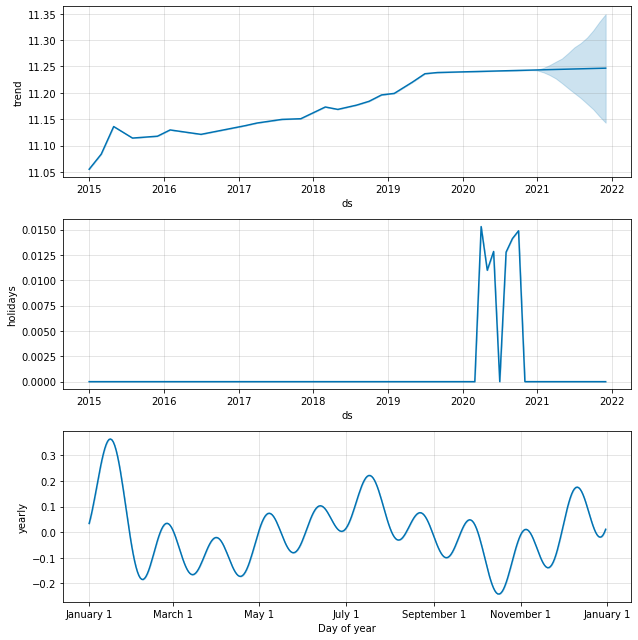

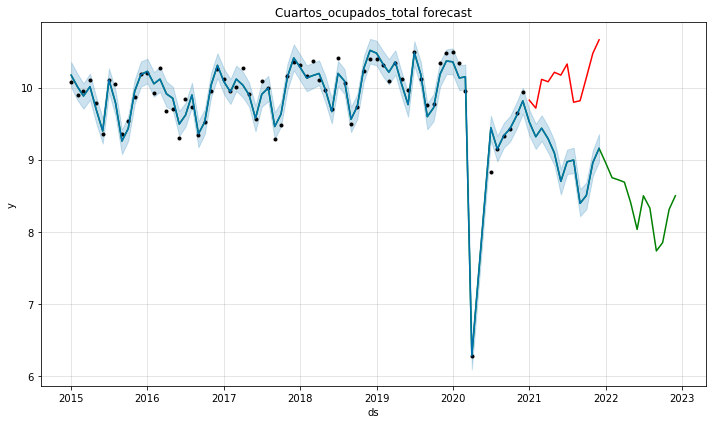

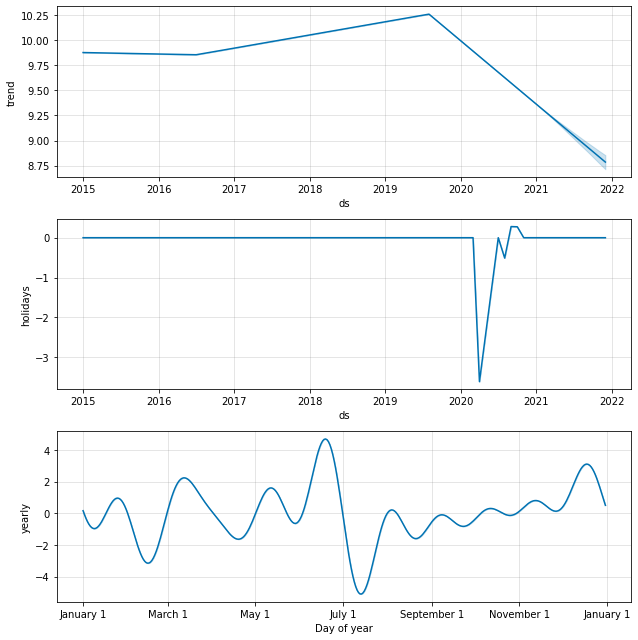

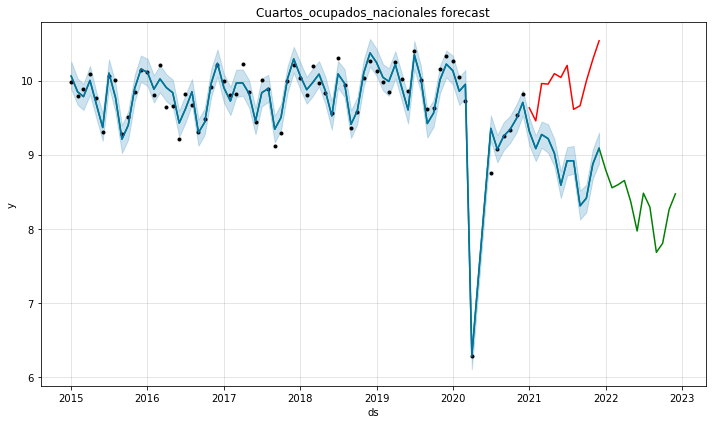

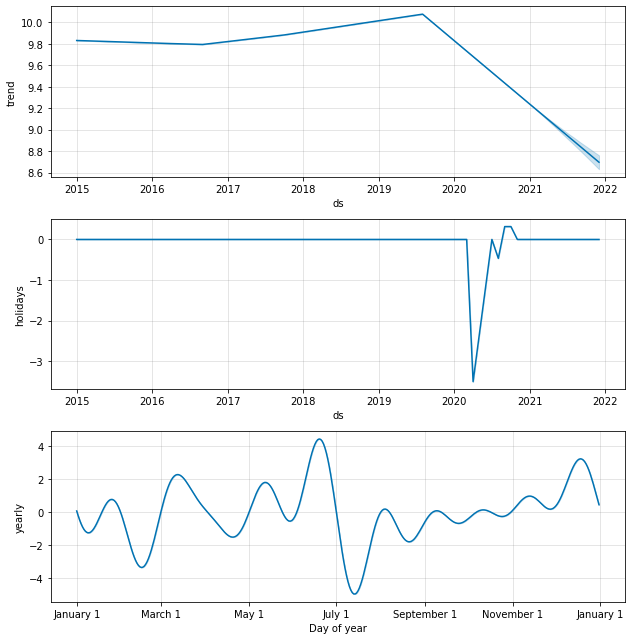

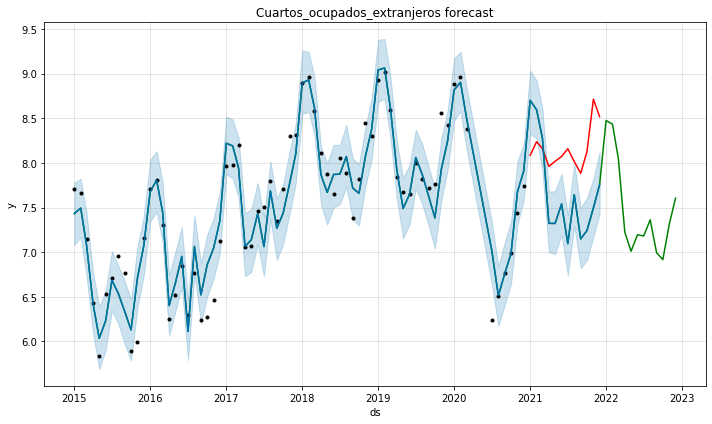

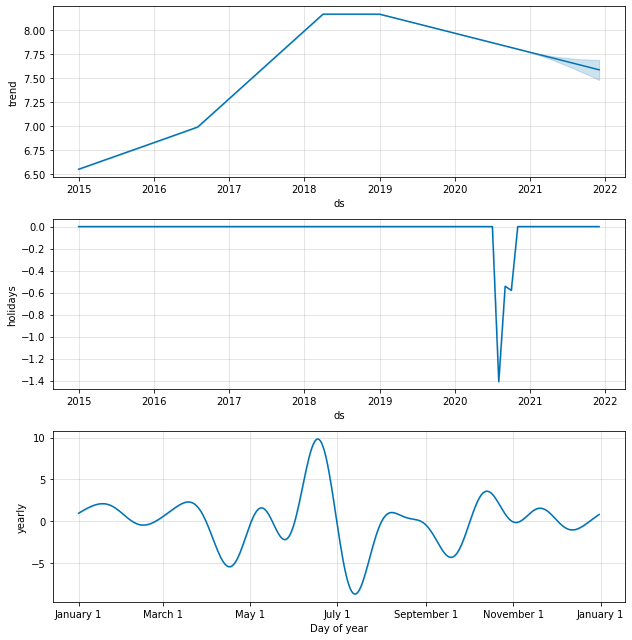

In [15]:
# Modelos nominales con estacionalidad aditiva tomando en cuenta el covid
time_series_forecasting_covid(nominales, 12, 'additive')

In [ ]:
# Modelos porcentuales con estacionalidad aditiva tomando en cuenta el covid
time_series_forecasting_covid(porcentajes, 12, 'additive')